In [1]:
import cobra
import os
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis.deletion import single_reaction_deletion
from cobra.flux_analysis.parsimonious import add_pfba

In [2]:
models = {}
model_dir = '../data/modelseed_models/'
for file in os.listdir(model_dir):
    if file.endswith('.json') and not file.endswith('gapfill_removed.json'):
        models[file.split('.json')[0]] = cobra.io.load_json_model(model_dir+file)

Academic license - for non-commercial use only


In [6]:
models

('B. longum subsp. longum_gapfill_removed.json', '.json')

In [4]:
for species,model in models.items():
    print(species,model.optimize())

L. lactis <Solution 37.156 at 0x11d8a1550>
B. vulgatus HM-720 <Solution 117.820 at 0x11d8a14a8>
B. clarus <Solution 114.214 at 0x11d8a1550>
P. distasonis <Solution 111.619 at 0x11d8a14a8>
B. longum subsp. infantis <Solution 55.913 at 0x11d8a1550>
C. saccharolyticum <Solution 39.492 at 0x11d8a14a8>
L. plantarum <Solution 56.319 at 0x11d8a1550>
B. longum subsp. longum <Solution 47.898 at 0x11d8a14a8>
P. merdae <Solution 97.011 at 0x11d8a1550>
R. gnavus <Solution 25.340 at 0x11d8a14a8>


In [5]:
# get the mapping of exchange reactions to metabolite names for every exchange reaction
ex_to_name = {}
for species in models.keys():
    ex_rxns = [r.id for r in models[species].reactions if r.id.startswith('EX_')]
    for rxn in ex_rxns:
        if rxn not in ex_to_name.keys():
            ex_to_name[rxn] = models[species].reactions.get_by_id(rxn).reactants[0].name

In [6]:
# First, perform FVA for each of the species for later comparison with iterative pFBA
fva_results = {}
consumed_mets = {}
produced_mets = {}
for species,model in models.items():
    model.solver='glpk'
    print("performing FVA for {}".format(species))
    ex_rxns = [r.id for r in model.reactions if r.id.startswith('EX_')]
    fva_results[species] = flux_variability_analysis(model,ex_rxns, fraction_of_optimum = 0.05)
    
    # get consistently consumed and produced metabolites from exchanges
    consumed_mets[species] = fva_results[species].loc[(fva_results[species] < -1e-6).sum(axis=1) > 1]
    produced_mets[species] = fva_results[species].loc[(fva_results[species] > 1e-6).sum(axis=1) > 1]
    

performing FVA for L. lactis
performing FVA for B. vulgatus HM-720
performing FVA for B. clarus
performing FVA for P. distasonis
performing FVA for B. longum subsp. infantis
performing FVA for C. saccharolyticum
performing FVA for L. plantarum
performing FVA for B. longum subsp. longum
performing FVA for P. merdae
performing FVA for R. gnavus


In [7]:
# extract the lowest uptake rates
species_consumption_series = {species:consumed_mets[species]['maximum'] for species in consumed_mets.keys()}
uptake_frame = pd.DataFrame(species_consumption_series)
uptake_frame = uptake_frame.fillna(0).T

In [8]:
# extract the highest secretion rates
species_production_series = {species:produced_mets[species]['minimum'] for species in produced_mets.keys()}
secretion_frame = pd.DataFrame(species_production_series)
secretion_frame = secretion_frame.fillna(0).T

In [9]:
# merge the secretion and uptake dataframes, then normalize by the absolute max secretion/uptake
con_prod_frame = secretion_frame.add(uptake_frame, fill_value=0)

# normalize by max(abs)
con_prod_frame = con_prod_frame.divide(abs(con_prod_frame).max(axis=1),axis=0)
# filter out metabolites with uptakes lower than 5% of max for all species
con_prod_frame = con_prod_frame[con_prod_frame.columns[abs(con_prod_frame).max() > 0.05]]
# Filter out metabolites for display
exclude = ['EX_cpd00001_e','EX_cpd00007_e'] # H2O, Oxygen, 
con_prod_frame = con_prod_frame[[col for col in con_prod_frame.columns if col not in exclude]]

In [10]:
con_prod_frame

,EX_cpd00009_e,EX_cpd00012_e,EX_cpd00013_e,EX_cpd00023_e,EX_cpd00036_e,EX_cpd00039_e,EX_cpd00051_e,EX_cpd00060_e,EX_cpd00064_e,EX_cpd00065_e,...,EX_cpd01188_e,EX_cpd03198_e,EX_cpd03847_e,EX_cpd10516_e,EX_cpd11583_e,EX_cpd11584_e,EX_cpd11606_e,EX_cpd15603_e,EX_cpd15605_e,EX_cpd15606_e
L. lactis,0.000000,0.000000,0.0,0.000000,0.000000,-0.276167,-0.164086,0.000000,0.164086,0.000000,...,0.000000,0.000000,0.000000,-0.013473,-0.34136,-0.069528,0.000000,0.00000,0.000000,0.000000
B. vulgatus HM-720,-0.149160,0.000000,-1.0,0.000000,0.000000,-0.062792,0.000000,-0.026476,0.000000,0.000000,...,0.000000,0.000000,-0.030352,-0.001487,0.00000,0.000000,-0.001879,0.00000,0.000000,0.000000
B. clarus,0.000000,0.000000,0.0,0.000000,0.000000,-0.949434,0.000000,-0.400320,0.000000,0.000000,...,0.000000,0.000000,-0.458934,-0.023675,0.00000,0.000000,-0.018940,0.00000,0.000000,0.000000
P. distasonis,-1.000000,0.000000,0.0,0.000000,0.000000,-0.419166,-0.626509,0.000000,0.000000,-0.063732,...,0.000000,0.000000,-0.202615,-0.008362,0.00000,-0.107021,-0.012542,-0.27955,-0.208631,-0.162937
B. longum subsp. infantis,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.180595,0.000000,-0.059493,...,-0.064297,0.000000,-0.189140,-0.007806,0.00000,0.000000,-0.007806,0.00000,0.000000,0.000000
C. saccharolyticum,0.000000,0.000000,0.0,0.000000,0.058719,0.000000,0.000000,-0.718381,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.073399,0.00000,0.000000,-0.058719,0.00000,0.000000,0.000000
L. plantarum,0.000000,0.000000,0.0,0.000000,0.000000,-0.276168,0.000000,-0.129978,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.013473,0.00000,0.000000,-0.013473,0.00000,0.000000,0.000000
B. longum subsp. longum,0.000000,-0.211724,0.0,0.000000,0.000000,0.000000,0.000000,-0.080341,0.000000,-0.026467,...,-0.028604,0.000000,-0.084143,-0.003472,0.00000,0.000000,-0.003472,0.00000,0.000000,0.000000
P. merdae,-0.121947,0.000000,0.0,0.000000,0.000000,-0.047716,-0.087890,0.000000,0.000000,-0.006779,...,-0.007286,0.000000,-0.023065,-0.000952,0.00000,-0.012183,-0.001428,0.00000,-0.023750,-0.018548
R. gnavus,-1.000000,0.000000,0.0,-0.741877,0.013294,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.258545,0.000000,-0.013294,0.00000,0.000000,-0.013294,0.00000,0.000000,0.000000


In [11]:
# Perform the same kind of analysis using shadow prices as well. This probably won't be particularly useful.
shadow_price_dict = {}
for species,model in models.items():
    medium = model.medium
    medium = {cpd:1 for cpd in medium.keys()}
    model.medium = medium
    shadow_prices = model.optimize().shadow_prices
    shadow_prices = shadow_prices[[cpd for cpd in shadow_prices.index if cpd.endswith('_e')]]
    shadow_price_dict[species] = shadow_prices
    
shadow_price_frame = pd.DataFrame(shadow_price_dict)
shadow_price_frame = shadow_price_frame.fillna(0)

# remove metabolites with small shadow prices
shadow_price_frame = shadow_price_frame.loc[abs(shadow_price_frame).max(axis=1) > 1e-8].T

#normalize shadow prices by the max(abs) for each species
shadow_price_frame = shadow_price_frame.divide(abs(shadow_price_frame).max(axis=1),axis=0)

In [189]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
# set the colormap and centre the colorbar - from http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


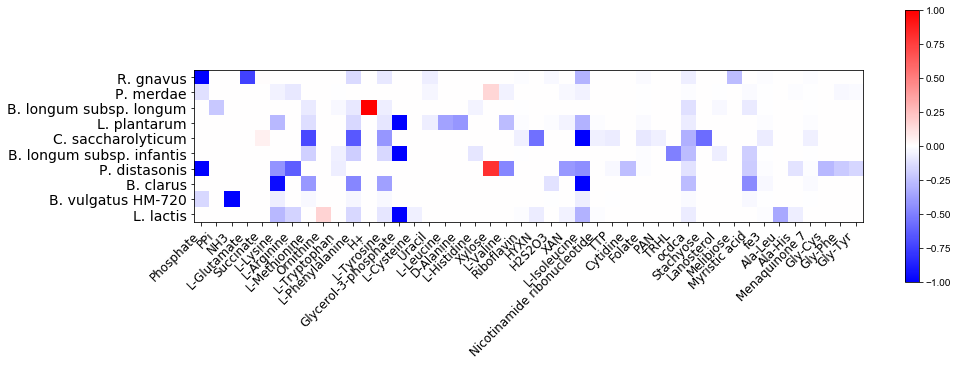

In [14]:
fig,ax = plt.subplots()
plt.rcParams["font.family"] = "Arial"

elev_min=con_prod_frame.min().min()
elev_max=con_prod_frame.max().max()
mid_val=0

im= ax.imshow(con_prod_frame.values, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax.set_xticks(np.arange(len(con_prod_frame.columns)))
ax.set_yticks(np.arange(len(con_prod_frame.index)))
ax.set_ylim((-0.5,len(con_prod_frame.index)-0.5))
labels = [ex_to_name[exchange] for exchange in con_prod_frame.columns]
ax.set_xticklabels(labels, rotation = 45, ha = 'right', size=12)

# convert xtick labels to metabolite names
ax.set_yticklabels(con_prod_frame.index, size=14)
plt.colorbar(im)
fig.set_size_inches(15,5)
plt.savefig('../results/fva_filtered.svg')

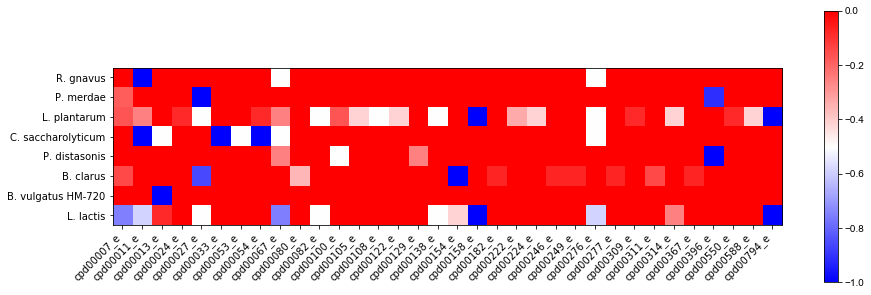

In [34]:
# Plot the shadow prices
fig,ax = plt.subplots()
im = ax.imshow(shadow_price_frame.values, cmap = 'bwr')
ax.set_xticks(np.arange(len(shadow_price_frame.columns)))
ax.set_yticks(np.arange(len(shadow_price_frame.index)))
ax.set_ylim((-0.5,len(shadow_price_frame.index)-0.5))
ax.set_xticklabels(shadow_price_frame.columns, rotation = 45, ha = 'right')
ax.set_yticklabels(shadow_price_frame.index)
plt.colorbar(im)
fig.set_size_inches(15,5)

In [158]:
# Here is the preliminary implementation of iterative pFBA.
minimum_auxotrophies = {}
minimum_growth = {} # for each strain, get the growth rate when only auxotrophic metabolites are available
consumed_dicts = {}
produced_dicts = {}


for strain in models.keys():
    print(strain)
    strain_model = models[strain].copy()
    #strain_model.reactions.EX_cpd00007_e.lower_bound=0 # this line would shut off O2 uptake
    #strain_model.reactions.EX_cpd00011_e.lower_bound=0 # this line would shut off CO2 uptake
    essential_threshold = 0.01
    max_growth = strain_model.slim_optimize()
    consumed_dict = {}
    produced_dict = {}
    
    # Create a list of exchange reactions that should never be shut off
    # H+, H2O
    exclusion_list = ['EX_cpd00067_e','EX_cpd00001_e']

    exclude_exchange = [] # running list of exchange reactions to shut off; updated at end of each iteration
    minimum_auxotrophies[strain] = [] # list of exchange reactions that are essential at the lowest growth rate
                                      # (i.e., during the last iteration)
    while not minimum_auxotrophies[strain]: # iterate until the growth threshold can't be met
        with strain_model as model:
            # Inactivate excluded exchange reactions from previous iterations
            for reaction in exclude_exchange:
                model.reactions.get_by_id(reaction).lower_bound = 0
            media_rxns = model.medium.keys() # get current medium
            current_growth = model.slim_optimize() # get current growth rate
            
            # perform single reaction deletions for media components and identify those that reduce growth below the threshold
            deletion_results = single_reaction_deletion(model,media_rxns)
            essential = [list(i)[0] for i in deletion_results.loc[deletion_results['growth'] < essential_threshold * current_growth].index]
            
            # add pFBA constraints and objective, then optimize
            add_pfba(model,fraction_of_optimum=1.0)
            pfba_sol = model.optimize()
            
            # extract the active media fluxes only from the pFBA solution
            active = pfba_sol.fluxes.loc[abs(pfba_sol.fluxes) > 0]
            active_media = active[[rxn for rxn in model.medium.keys() if rxn in active.index]]

            # remove the essential reactions from the active_media list
            active_nonessential = active_media[[i for i in active_media.index if i not in essential]].sort_values()
            
            # filter out reactions from the exclusion list that we deemed constitutively essential
            active_nonessential = active_nonessential[list(set(active_nonessential.index) - set(exclusion_list))]
            
            # identify consumed and produced metabolites, then get the reaction with the maximum consumption rate
            if len(active_nonessential[active_nonessential < 0]) > 0:
                produced = active_nonessential[active_nonessential > 0].sort_values(ascending=True)
                for metabolite in produced.index:
                    if metabolite in produced_dict.keys():
                        produced_dict[metabolite].append({'production_flux':produced[metabolite],'growth_rate':current_growth})
                    else:
                        produced_dict[metabolite] = [{'production_flux':produced[metabolite],'growth_rate':current_growth}]
                max_consumed = active_nonessential[active_nonessential < 0].sort_values(ascending=False).index[-1]
                #produced_dict[max_produced] = active_media[max_produced]
                consumed_dict[max_consumed] = (active_media[max_consumed],current_growth)

                print(max_consumed,model.reactions.get_by_id(max_consumed).name,active_media[max_consumed],current_growth)
                #print(max_produced,model.reactions.get_by_id(max_produced).name,active_media[max_produced],current_growth)
                # shut off the exchange reaction for the max consumed metabolite
                exclude_exchange.append(max_consumed)
            
            # If none of the exchange reactions that aren't "auxotrophic" were active, record the last set of esssential reactions,
            # the growth rate at this step (which is the minimum growth rate obtained across all iterations).
            # Entering this else block should always kill the while loop.
            else:
                consumed_dicts[strain] = consumed_dict
                produced_dicts[strain] = produced_dict
                minimum_auxotrophies[strain] = essential
                minimum_growth[strain] = current_growth

L. lactis
EX_cpd00154_e Xylose exchange -1.0 0.11262122813104908
EX_cpd00794_e TRHL exchange -1.0 0.1058368167978531
EX_cpd00011_e CO2 exchange -1.0 0.08955422959818377
EX_cpd00138_e D-Mannose exchange -1.0 0.0800560537312373
EX_cpd00082_e D-Fructose exchange -1.0 0.07191476013184876
EX_cpd00276_e GLUM exchange -1.0 0.0637734665320398
EX_cpd00013_e NH3 exchange -1.0 0.053897559030532255
EX_cpd00158_e CELB exchange -1.0 0.05052896159113282
EX_cpd00314_e D-Mannitol exchange -1.0 0.034359693881961736
EX_cpd00007_e O2 exchange -1.0 0.030317376954674666
EX_cpd00027_e D-Glucose exchange -1.0 0.02035323399958681
EX_cpd00100_e Glycerol exchange -0.00504225563563948 0.012211940399752036
B. vulgatus HM-720
EX_cpd01217_e Xanthosine exchange -0.3821107905386888 0.20226137639403813
EX_cpd00027_e D-Glucose exchange -0.48317420790394255 0.20226137639403746
EX_cpd00396_e L-Rhamnose exchange -0.44123111028320366 0.2022613763940387
EX_cpd00154_e Xylose exchange -0.7215259981782278 0.202261376394039
EX_c

In [244]:
# Normalize the iterative pFBA results by converting the fluxes to yields (i.e., divide the flux by the growth rate)
production_coupling = {}
consumption_coupling = {}
for strain in consumed_dicts.keys():
    production_mean_growth = {}
    for metabolite in produced_dicts[strain].keys():
        production_mean_growth[metabolite] = [i['production_flux']/(i['growth_rate']) for i in produced_dicts[strain][metabolite]]
        production_mean_growth[metabolite] = np.mean(production_mean_growth[metabolite])

    consumed_growth = {}
    for metabolite in consumed_dicts[strain].keys():
        consumed_growth[metabolite] = (consumed_dicts[strain][metabolite][1])/consumed_dicts[strain][metabolite][0]
    
    production_coupling[strain] = production_mean_growth
    consumption_coupling[strain] = consumed_growth

In [304]:
# Combine the production and consumption results into a single dataframe for visualization
all_coupling = {strain:{**production_coupling[strain],**consumption_coupling[strain]} for strain in consumption_coupling.keys()}
all_coupling = pd.DataFrame(all_coupling)
all_coupling = all_coupling.fillna(0)
# replace all values greater than or less than 1000 with 0
#all_coupling[abs(all_coupling) > 500] = 0
# scale all entries within a strain by the strain max
all_coupling = all_coupling.divide(abs(all_coupling).max(axis=1),axis=0)
all_coupling = all_coupling.T
# replace all values in lowest 0.01 with 0
#all_coupling[abs(all_coupling) < 0.01] = 0

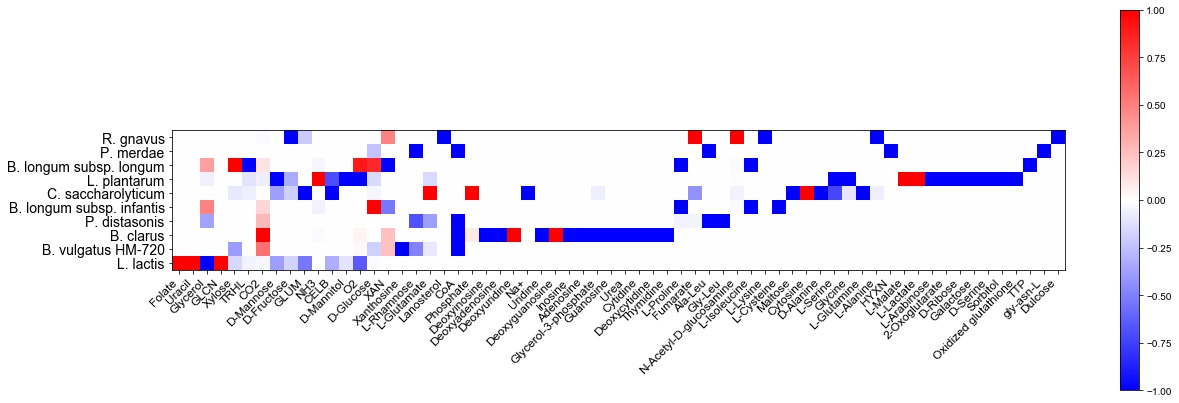

In [306]:
# Plot the iterative pFBA results
fig,ax = plt.subplots()
plt.rcParams["font.family"] = "Arial"

elev_min=all_coupling.min().min()
elev_max=all_coupling.max().max()
mid_val=0

im= ax.imshow(all_coupling.values, cmap='bwr', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

#im = ax.imshow(con_prod_frame.values, cmap = 'bwr')
ax.set_xticks(np.arange(len(all_coupling.columns)))
ax.set_yticks(np.arange(len(all_coupling.index)))
ax.set_ylim((-0.5,len(all_coupling.index)-0.5))
labels = [ex_to_name[exchange] for exchange in all_coupling.columns]
ax.set_xticklabels(labels, rotation = 45, ha = 'right', size=12)
# convert xtick labels to metabolite names

ax.set_yticklabels(all_coupling.index, size=14)
plt.colorbar(im)
fig.set_size_inches(20,7)
plt.savefig('../results/iter_pfba_filtered.svg')